In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit 

# The Feedforward Inhibition (FFI) Model

In this notebook, we will implement the feedforward inhibition model as adapted from (Turner et al., 2016). The model can be formulated as follows:

$$
\begin{align}
    \mathrm{d}X_i    &= (v_i - I_f(i))\mathrm{d}t + \sigma \mathrm{d}W_t, \\
    I_f(i)  &= \frac{\alpha}{J - 1} \sum_{j \neq i}^J v_j, \\
    X_{it}  &= \max{\{X_{it}, 0\}},
\end{align}
$$

where
- $\mathrm{d}X_i$ -- infinitesimal change in activation of the $i$-th accumulator;
- $v_i$ -- drift rate of the $i$-th accumulator;
- $I_f(i)$ -- inhibition term for the $i$-th accumulator;
- $\mathrm{d}t$ -- time step;
- $\sigma$ -- variance for the diffusion coefficient;
- $\mathrm{d}W_t$ -- infinitesimal Gaussian random increment;
- $\alpha \in \mathbb{R}_+$ -- strength of feedforward inhibition. 

In [3]:
# Simulations
def simulate_ffi(v, x0, a, alpha, tau, dt=1e-3, scale=1.0, max_time=10.):
    """
    Simulates one realization of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------
    v     : np.ndarray
        The drift rates (rates of information uptake)
    x0    : np.ndarray
        The starting points
    a     : float
        The boundary separation (decision threshold).
    alpha : float in [0, inf+)
        Inhibition parameter
    tau   : float [0 , inf+)
        Non-decision time (additive constant)
    dt    : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time: float, optional (default: 10.)
        The maximum number of seconds before forced termination.

    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and a 
        binary decision (c - int) 
    """

    # Initial conditions
    num_steps = tau
    const = scale * np.sqrt(dt)
    x = x0.copy()

    # Ensures that the starting points all have designated drift rates.
    assert x.shape[0] == v.shape[0]
    J = x0.shape[0]


    while num_steps <= max_time:

        z = np.random.randn(J)

        for j in range(J):
            dx_j = (v[j] - (sum(x) - x[j]) * alpha / (J-1))*dt + const * z[j]
            x[j] = max(x[j] + dx_j, 0)
        
        # Increment step counter
        num_steps += dt

        # Check for boundary hitting
        if any(x >= a):
            break
    
    return (round(num_steps, 3), x.argmax())

def simulate_ffi_n(num_sims, **kwargs):
    """ 
    Simulate a number of time series for response-time tasks
    using the feed-forward inhibition (FFI) model.

    Parameters
    ----------
    num_sims    : int
        Number of simulation runs.
    
    Returns
    -------
    data        : np.ndarray with shape(num_sims, )
        Dataset for the number of simulation runs.
    """
    data = np.zeros((num_sims, 2))
    for n in range(num_sims):
        data[n, :] = simulate_ffi(**kwargs)
    return data

In [5]:
# Simulation parameters
ffi_params = {
    'a': 1.,
    'tau': 0.5,
    'alpha': 0.6
}

ffi_2 = { 'v': np.array([1., 1.]), 'x0': np.zeros(2) }
ffi_3 = { 'v': np.array([1., 1., 1.]), 'x0': np.zeros(3) }
ffi_4 = { 'v': np.array([1., 1., 1., 1.]), 'x0': np.zeros(4) }

# Simulator (for n_obs)
sim_2 = simulate_ffi_n(500, **{**ffi_params, **ffi_2})
sim_3 = simulate_ffi_n(500, **{**ffi_params, **ffi_3})
sim_4 = simulate_ffi_n(500, **{**ffi_params, **ffi_4})

In [6]:
# Helper function for plotting
def plot_ffi_simulation(sim_data, params):
    f, ax = plt.subplots(1, 1, figsize=(8, 4))
    colors = ['#A4343A', '#EAAA00', '#789D4A', '#007396']
    for j in range(params['v'].shape[0]):
        sns.histplot(sim_data[:, 0][sim_data[:, 1] == j], color=colors[j], label=f'Alternative {j}')
    ax.legend()
    sns.despine(ax=ax)
    ax.set_xlabel('Response time (s)', fontsize=16)
    ax.set_ylabel('')
    ax.set_yticklabels([])
    ax.set_yticks([])
    f.tight_layout()

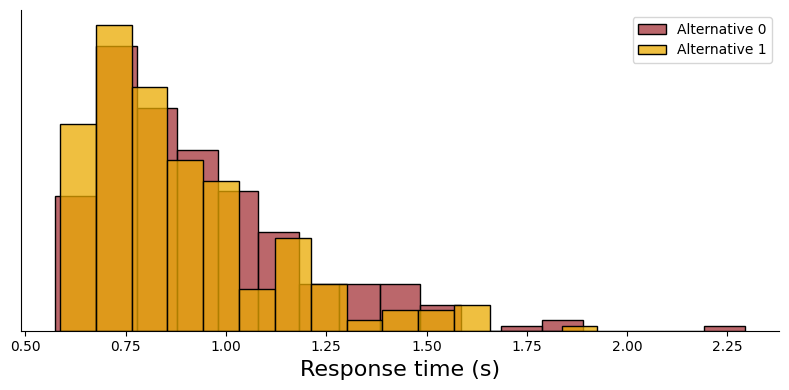

In [9]:
plot_ffi_simulation(sim_2, ffi_2)

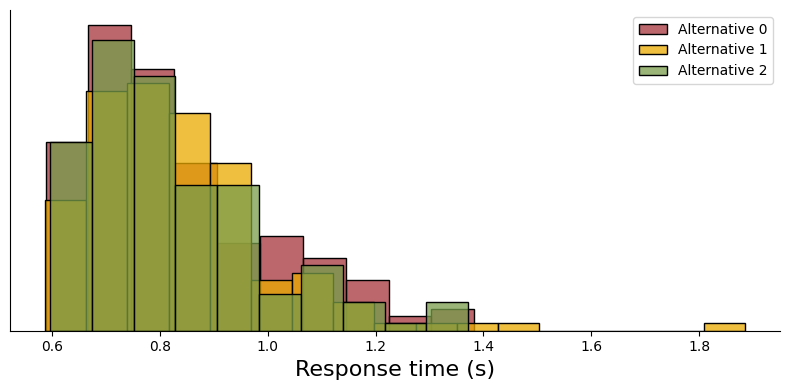

In [10]:
plot_ffi_simulation(sim_3, ffi_3)

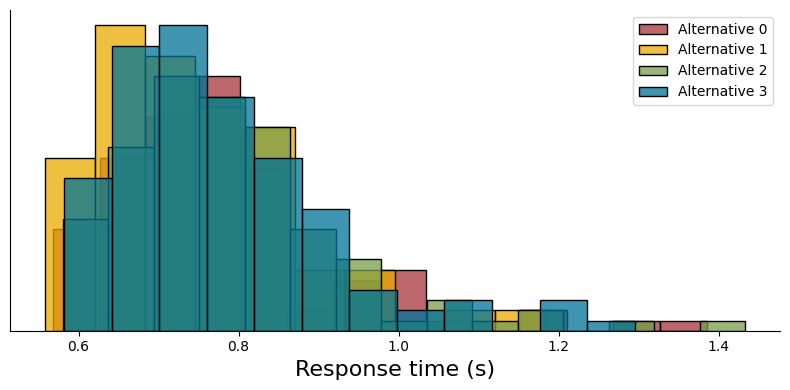

In [11]:
plot_ffi_simulation(sim_4, ffi_4)